In [ ]:
!mamba install pytorch=1.12 torchvision torchaudio cudatoolkit=11.3 -c pytorch -y -q

In [ ]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.12.0+cu113.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.12.0+cu113.html
!pip install torch-geometric

In [ ]:
!mamba install -c conda-forge pyts -q -y

In [ ]:
!pip install llvmpy
!pip install cython
!pip install numba
!pip install pandas
!pip install networkx
!pip install matplotlib
!pip install ts2vg

In [41]:
import pandas as pd
import numpy as np
import torch
import warnings
import networkx as nx
import ts2vg
import matplotlib.pyplot as plt

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from pyts.image import MarkovTransitionField
from torch_geometric.utils.convert import to_networkx
from matplotlib import pyplot
from ts2vg import NaturalVG
from ts2vg import HorizontalVG
from sklearn.utils import class_weight

In [56]:
#usualy there was a sample with length not equal to the others, that is why we need X_repair
def anomaly_finder():
    anomaly = []
    X_temp = np.load(dataFileName, mmap_mode=None, allow_pickle=True)
    for i in range(len(X_temp)):
        if len(X_temp[i]) != len(X_temp[0]):
            anomaly = np.append(anomaly, i)
    return anomaly

# converts words to numbers
def anomaly_numeric(Y):
    labels = np.empty([len(Y)-1,1], dtype=int)
    t = Y[0]
    k = 0
    count = 0
    for i in range(len(Y)):
        if i not in hidden_anomaly:#hidden_anomaly: #76407,39617,21019,11832
            if Y[i] != t:
                count += 1
                t = Y[i]
            labels[i-k] = count
        else:
            k = 1
            
    return labels.reshape(1,-1)[0]

# maps every utility number and number location in anomaly_numeric()
def location_of_labels(Y_temp):
    range_labels = np.empty([max_samp,4], dtype='<U21')
    t = 'n'
    count1 = 0
    count2 = 0
    count3 = 0
    k = 0
    for i in range(len(Y_temp)):
        if i not in hidden_anomaly:#hidden_anomaly: #76407,39617,21019,11832
            count3 += 1
            if count1 != 0:
                #length of samples for a given utility
                range_labels[count1-1][2] = count3
            
            if t != Y_temp[i]:
                
                #sequence number
                range_labels[count1][0] = count1
                
                #name of utility per sequence number
                range_labels[count1][1] = Y_temp[i]
                
                #where the sequence number represents the given utility samples
                range_labels[count1][3] = count2
                
                t = Y_temp[i]
                count1 += 1
                count3 = 0
            count2 += 1

    return range_labels

#Fix X weird shape
def X_repair(X_temp):
    X = np.empty([len(X_temp)-1,len(X_temp[0])], dtype='float64')
    k = 0
    for i in range(len(X_temp)):
        if i not in hidden_anomaly: #hidden_anomaly: #76407,39617,21019,11832
            for j in range(len(X[0])):
                X[i-k][j] = X_temp[i][j]
        else:
            k = k + 1 
    return X

#reduce length so all utilities have the same number of samples
def X_reduce_length_to_shortest(X,lol):
    
    length_X = (lol[:,2].astype('int').min()-1) *2
    
    dimensions = 0
    for i in range(len(lol)):
        if lol[i][2].astype('int') > length_X:
            dimensions += length_X
        else:
            dimensions += lol[i][2].astype('int')
    
    X_new = np.empty([dimensions,len(X[0])], dtype='float64')
    Y = np.empty([dimensions,1], dtype=int)
    
    temp_len = 0
    temp_temp = 0
    temp = 0
    for i in range(len(lol)):
        for j in range(length_X):
            if lol[i][2].astype('int') > j:
                Y[temp_temp + j] = i
                X_new[temp_temp + j] = X[j + temp]
                temp_len = j+1
    
        temp = temp + lol[i][2].astype('int')
        lol[i][2] = temp_len
        lol[i][3] = temp_temp
        temp_temp = temp_temp + temp_len
        temp_len = 0
        
    return X_new, Y.reshape(1,-1)[0], lol

In [44]:
# creates the graph 
def create_join_graph(cut, n_bins = 150):
    
    warnings.filterwarnings("ignore")    
    global lol, hidden_anomaly, max_samp
    
    #checks if there are any shapes that do not fit others
    hidden_anomaly = anomaly_finder()
    
    # preparation for creating a graph
    Y_temp = np.load(labelsFileName, mmap_mode=None, allow_pickle=False)
    Y = anomaly_numeric(Y_temp)
    
    #for visualisation of what is where in the dataset
    max_samp = Y.max()+1
    lol = location_of_labels(Y_temp)
    
    X_temp = np.load(dataFileName, mmap_mode=None, allow_pickle=True)
    X = X_repair(X_temp)
    X, Y, lol = X_reduce_length_to_shortest(X,lol)
        
    MTF = MarkovTransitionField(n_bins = n_bins)
    X_gaf = MTF.fit_transform(X)
    
    output= []

    global class_weights
    class_weights = torch.tensor(class_weight.compute_class_weight(class_weight='balanced',
                                                                   classes=np.unique(Y),
                                                                   y=Y))
        
    def adjToEdgidx(adj_mat_MTF,X_current):
        g = NaturalVG(weighted='distance')
        #g = HorizontalVG(weighted='distance')
        g.build(X_current)
        
        #create matrix for visual
        adj_mat_visual = np.zeros([len(adj_mat_MTF),len(adj_mat_MTF)], dtype='float')
        for i in range(len(g.edges)):
            x, y, q =g.edges[i]
            adj_mat_visual[x,y] = q#/g.weights.max()
            adj_mat_visual[y,x] = q#/g.weights.max()
        
        edge_index = torch.from_numpy(adj_mat_MTF).nonzero().t().contiguous()
        
        #join two edge_weight arrays (visual is converted to fit MTF) 
        row, col = edge_index
        edge_weight = np.zeros([len(row),2], dtype='float')
        edge_weight[:,0] = adj_mat_MTF[row, col]
        edge_weight[:,1] = adj_mat_visual[row, col]
        
        # edge_weight = np.reshape(edge_weight,(len(edge_weight),2))
        
        return edge_index, edge_weight
    
    for i, j in enumerate(X_gaf):
        edge_index, edge_weight = adjToEdgidx(j,X[i])
        #Into Data save node values "x", edge index from adjacency matrix and edge features/attributes, finally labels       
        output.append(Data(x=torch.unsqueeze(torch.tensor(X[i], dtype=torch.double),1), 
                    edge_index=edge_index, 
                    edge_attr=torch.tensor(edge_weight, dtype=torch.double), 
                    y=torch.tensor(Y[i], dtype=torch.long)))
    return output

In [45]:
# creates the visual graph 
def create_visual_graph(cut):
    warnings.filterwarnings("ignore")
    
    global lol, hidden_anomaly, max_samp
    
    hidden_anomaly = anomaly_finder()
    
    Y_temp = np.load(labelsFileName, mmap_mode=None, allow_pickle=False)
    Y = anomaly_numeric(Y_temp)
    
    #for visualisation of what is where in the dataset
    max_samp = Y.max()+1
    lol = location_of_labels(Y_temp)
    
    X_temp = np.load(dataFileName, mmap_mode=None, allow_pickle=True)
    X = X_repair(X_temp)
    
    if cut == True:
        X, Y, lol = X_reduce_length_to_shortest(X,lol)
        
    output = []
    
    from sklearn.utils import class_weight
    global class_weights
    class_weights = torch.tensor(class_weight.compute_class_weight(class_weight='balanced',
                                                                   classes=np.unique(Y),
                                                                   y=Y))

    def adjToEdgidx(X_current):
        g = NaturalVG(weighted='distance')
        # g = HorizontalVG(weighted='distance')
        g.build(X_current)

        adj_mat_visual = np.zeros([len(X_current),len(X_current)], dtype='float')
        for i in range(len(g.edges)):
            x, y, q =g.edges[i]
            adj_mat_visual[x,y] = q#/g.weights.max()
            adj_mat_visual[y,x] = q#/g.weights.max()
        
        edge_index = torch.from_numpy(adj_mat_visual).nonzero().t().contiguous()
        row, col = edge_index
        edge_weight = adj_mat_visual[row, col]
        
        # edge_weight = np.reshape(edge_weight,(len(edge_weight),2))
        
        return edge_index, edge_weight
    
#     for i in range(len(X)):
#         g = NaturalVG(weighted='distance')
#         #g = HorizontalVG(weighted='distance')
#         g.build(X[i])

#         edges = np.array(g.edges)
#         edge_index = np.reshape(edges[:,:2],(2,len(edges)))
        
#         weights = np.array(g.weights)
#         edge_attr = (weights/weights.max())
        
    for i in range(len(X)):
        edge_index, edge_weight = adjToEdgidx(X[i])
        output.append(Data(x=torch.unsqueeze(torch.tensor(X[i], dtype=torch.double),1), 
                           edge_index=torch.tensor(edge_index, dtype=torch.int64), 
                           edge_attr=torch.unsqueeze(torch.tensor(edge_weight, dtype=torch.double),1),
                           y=torch.tensor(Y[i], dtype=torch.long) ))
    return output

In [46]:
# creates the graph 
def create_graph(cut, n_bins = 150):
    
    warnings.filterwarnings("ignore")
    global lol, hidden_anomaly, max_samp
    
    hidden_anomaly = anomaly_finder()
    
    Y_temp = np.load(labelsFileName, mmap_mode=None, allow_pickle=False)
    Y = anomaly_numeric(Y_temp)
    
    #for visualisation of what is where in the dataset
    max_samp = Y.max()+1
    lol = location_of_labels(Y_temp)
    
    X_temp = np.load(dataFileName, mmap_mode=None, allow_pickle=True)
    X = X_repair(X_temp)
    
    if cut == True:
        X, Y, lol = X_reduce_length_to_shortest(X,lol)
        
    MTF = MarkovTransitionField(n_bins = n_bins)
    X_gaf = MTF.fit_transform(X)
    output = []
    
    from sklearn.utils import class_weight
    global class_weights
    class_weights = torch.tensor(class_weight.compute_class_weight(class_weight='balanced',
                                                                   classes=np.unique(Y),
                                                                   y=Y))
    def adjToEdgidx(adj_mat):
        edge_index = torch.from_numpy(adj_mat).nonzero().t().contiguous()
        row, col = edge_index
        edge_weight = adj_mat[row, col]#adj_mat[row, col]
        return edge_index, edge_weight
    
    for i, j in enumerate(X_gaf):
        edge_index, edge_weight = adjToEdgidx(j)
        #Into Data save node values "x", edge index from adjacency matrix and edge features/attributes, finally labels       
        output.append(Data(x=torch.unsqueeze(torch.tensor(X[i], dtype=torch.double),1), 
                           edge_index=edge_index, 
                           edge_attr=torch.unsqueeze(torch.tensor(edge_weight, dtype=torch.double),1), 
                           y=torch.tensor(Y[i], dtype=torch.long)))
    
    return output

In [47]:
## Graph Clasification

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.CrossEntropyLoss):
    ''' Focal loss for classification tasks on imbalanced datasets '''

    def __init__(self, gamma=1, alpha=None, ignore_index=-100, reduction='mean'):
        super().__init__(weight=alpha, ignore_index=ignore_index, reduction='none')
        self.reduction = reduction
        self.gamma = gamma

    def forward(self, input_, target):
        cross_entropy = super().forward(input_, target)
        # Temporarily mask out ignore index to '0' for valid gather-indices input.
        # This won't contribute final loss as the cross_entropy contribution
        # for these would be zero.
        target = target * (target != self.ignore_index).long()
        input_prob = torch.gather(F.softmax(input_, 1), 1, target.unsqueeze(1))
        loss = torch.pow(1 - input_prob, self.gamma) * cross_entropy
        
        
        if self.reduction == 'mean':
            return torch.mean(loss) 
        elif self.reduction == 'sum':
            return torch.sum(loss) 
        else:
            return loss

In [49]:
import torch
import torch.nn.functional as F
from torch.nn import Linear, CrossEntropyLoss
from torch_geometric.nn import global_mean_pool, global_add_pool, global_max_pool, ChebConv, global_sort_pool
from torch.nn import Sequential, BatchNorm1d, ReLU, Dropout
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GINConv, GINEConv, GATv2Conv


class GINE(torch.nn.Module):
    """GIN"""
    def __init__(self, dim_h):
        super(GINE, self).__init__()
        edge_dim = 1
        
        
        self.conv1 = GINEConv(
            Sequential(Linear(dim_h, dim_h),
                       BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()), edge_dim=edge_dim)
        
        self.conv2 = GINEConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()), edge_dim=edge_dim)
        
        self.conv3 = GINEConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()), edge_dim=edge_dim)
        
        self.conv4 = GINEConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()), edge_dim=edge_dim)
        
        self.conv5 = GINEConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()), edge_dim=edge_dim)
    
        self.lin1 = Linear(dim_h*5, dim_h*5)
        self.lin2 = Linear(dim_h*5, max_samp)

    def forward(self, data):
        
        x, edge_index, edge_weight, batch = data.x, data.edge_index, data.edge_attr, data.batch
        
        # Node embeddings 
        h1 = self.conv1(x, edge_index, edge_attr=edge_weight)
        h2 = self.conv2(h1, edge_index, edge_attr=edge_weight)
        h3 = self.conv3(h2, edge_index, edge_attr=edge_weight)
        h4 = self.conv4(h3, edge_index, edge_attr=edge_weight)
        h5 = self.conv5(h4, edge_index, edge_attr=edge_weight)
        
        # Graph-level readout
        
        h1 = global_max_pool(h1, batch)
        h2 = global_max_pool(h2, batch)
        h3 = global_max_pool(h3, batch)
        h4 = global_max_pool(h4, batch)
        h5 = global_max_pool(h5, batch)
        
        # Concatenate graph embeddings
        h = torch.cat((h1, h2, h3, h4, h5), dim=1)
        
        # Classifier
        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)
        
        return h

In [50]:
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix

def trainG(model, loader, epoch, optimizer, device):
    model.train()
    total_loss = 0

    with tqdm(loader, unit="batch") as tepoch:
         for data in tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            optimizer.zero_grad()
            data = data.to(device)
            out = model(data)
            loss_function = CrossEntropyLoss(weight=class_weights.to(device))
            #loss_function = FocalLoss()
            loss = loss_function(out, data.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

def testG(model, loader, device):
    model.eval()

    correct = 0
    predicted_categories = []
    true_categories = []
    with tqdm(loader, unit="batch") as tepoch:
        for data in tepoch:
      # Iterate in batches over the training/test dataset.
            data = data.to(device)
            out = model(data)  
            pred = out.argmax(dim=1)# Use the class with highest probability.
            predicted_categories.append(pred.cpu().detach().numpy())
            true_categories.append(data.y.cpu().detach().numpy())
            correct += int((pred == data.y).sum())# Check against ground-truth labels.
    #print(confusion_matrix(true_categories, predicted_categories))
    #print(classification_report(true_categories, predicted_categories))  
    return (correct / len(loader.dataset)), true_categories, predicted_categories   # Derive ratio of correct predictions.


In [51]:
def graph_classification(visual = False, cut = False, n_bins = 150, batch_size = 64, range_epoch = 10, epoch_min = 0, epoch_interval = 50):
    
    # if visual == False:
    #     output = create_graph(cut, n_bins = n_bins)
    # else:
    #     output = create_visual_graph(cut)

    torch.manual_seed(6405)
    train_size = int(0.8 * len(output))
    test_size = len(output) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(output, [train_size, test_size])
    loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
    #________________Select model_________________________________________________
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    torch.cuda.empty_cache()

    model = GINE(32).double().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    #optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=5e-4)

    loss_plot = np.empty([range_epoch], dtype='float64')
    acc_plot = np.zeros([range_epoch], dtype='float64')
    best_score = 0
    for epoch in range(range_epoch):
        result = trainG(model, loader, epoch, optimizer, device)
        loss_plot[epoch] = result
        if epoch >= epoch_min:
            if epoch%epoch_interval == 0:
                score, true_categories, predicted_categories = testG(model, DataLoader(test_dataset, batch_size = 1), device)
                acc_plot[epoch] = score
                if best_score < score:
                    best_score = score
                    best_tcs = true_categories
                    best_pc = predicted_categories
                    best_e = epoch
    
    print('Done!')
    
    print(confusion_matrix(best_tcs, best_pc))
    print(classification_report(best_tcs, best_pc)) 
    print(best_e)
    return loss_plot, acc_plot

In [ ]:
dataFileName = 'SynD_data_120.npy'
labelsFileName = 'SynD_labels_120.npy'

#output = create_join_graph(cut=True, n_bins = 1200)
output = create_visual_graph(cut=True)


In [ ]:
loss_plot1, acc_plot1 = graph_classification(visual = True, cut = True, batch_size = 64*2, range_epoch = 1000, epoch_min = 0, epoch_interval = 5)

Epoch 197:  35%|███▌      | 6/17 [00:00<00:01,  7.11batch/s]

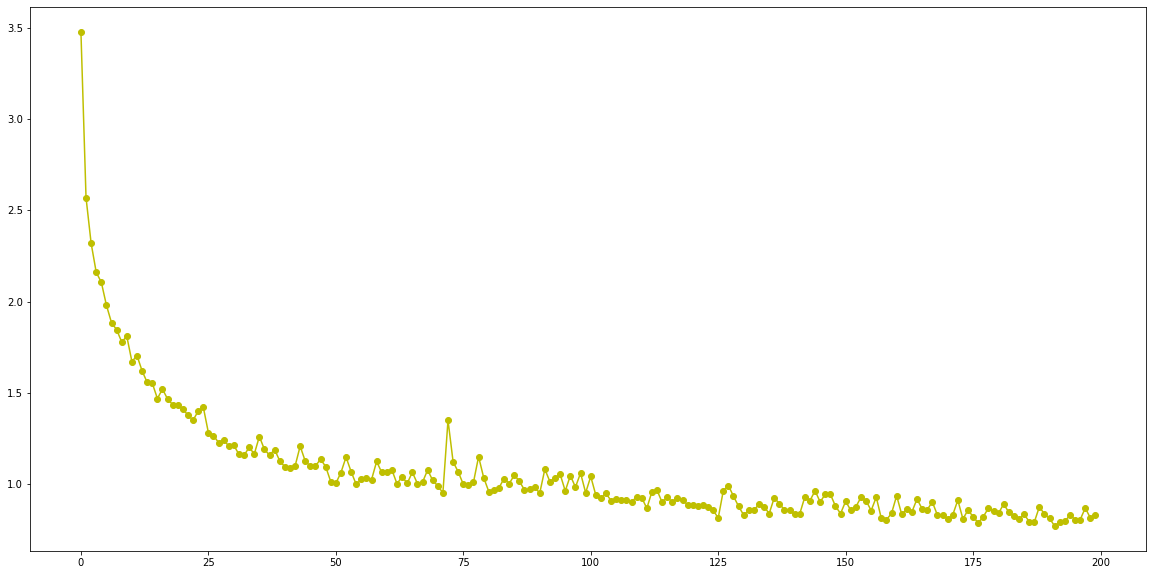

In [53]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

# plt.plot(loss_plot1, '-bo')# main visual, FocalLoss, bin = 1200
# plt.plot(loss_plot2, '-ro')# main visual, CrossEntropyLoss, bin = 1200
plt.plot(loss_plot1, '-yo')# main visual, FocalLoss, bin = 600
# plt.plot(loss_plot4, '-go')# main visual, FocalLoss, bin = 1200, *2
# plt.plot(loss_plot5, '-wo')# main visual, FocalLoss, bin = 1200, *4

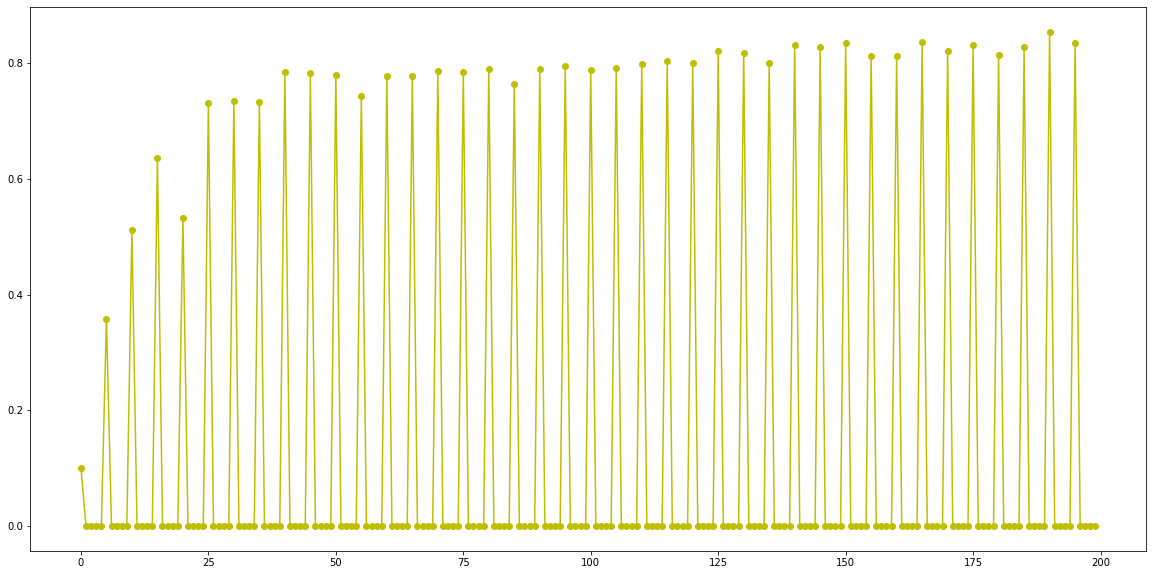

In [54]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

# plt.plot(acc_plot1, '-bo')
# plt.plot(acc_plot2, '-ro')
plt.plot(acc_plot1, '-yo')
# plt.plot(acc_plot4, '-go')
# plt.plot(acc_plot5, '-wo')